# AIM: develop the pretext task with EEGNet

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Pretext model & components:

### EEGNet:

In [2]:
# create Conv2d with max norm constraint
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm: int = 1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)
    
class EEGNet(nn.Module):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self,
                 chunk_size: int = 1244, # number of data points in each EEG chunk
                 num_electrodes: int = 26, # number of EEG electrodes
                 F1: int = 8, # number of filters in first convolutional layer
                 F2: int = 16, # number of filters in second convolutional layer
                 D: int = 2, # depth multiplier
                 num_extracted_features: int = 100, # number of features to extract
                 kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz))
                 kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz))
                 dropout: float = 0.25): # dropout rate
        super(EEGNet, self).__init__()
        self.F1 = F1
        self.F2 = F2
        self.D = D
        self.chunk_size = chunk_size
        self.num_extracted_features = num_extracted_features
        self.num_electrodes = num_electrodes
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.dropout = dropout

        self.block1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(self.F1,
                                 self.F1 * self.D, (self.num_electrodes, 1),
                                 max_norm=1,
                                 stride=1,
                                 padding=(0, 0),
                                 groups=self.F1,
                                 bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

        self.block2 = nn.Sequential(
            nn.Conv2d(self.F1 * self.D,
                      self.F1 * self.D, (1, self.kernel_2),
                      stride=1,
                      padding=(0, self.kernel_2 // 2),
                      bias=False,
                      groups=self.F1 * self.D),
            nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
            nn.Dropout(p=dropout))

        self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


    def feature_dim(self):
        # function to calculate the number of features after the convolutional blocks
        with torch.no_grad():
            mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

            mock_eeg = self.block1(mock_eeg)
            mock_eeg = self.block2(mock_eeg)

        return self.F2 * mock_eeg.shape[3]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.lin(x)
        return x

### pretext model:

In [3]:
class PretextModel(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self, num_extracted_features=100): # dropout rate
        super(PretextModel, self).__init__()
        # feature extractors
        self.EEGNet1 = EEGNet(num_extracted_features=num_extracted_features)
        self.EEGNet2 = EEGNet(num_extracted_features=num_extracted_features)
        
        # linear discriminate layer
        self.linear = nn.Linear(num_extracted_features, 1)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
        x1 = self.EEGNet1(x1) # forward pass through first EEGNet
        x2 = self.EEGNet2(x2) # forward pass through second EEGNet
        z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
        x = self.linear(z) # forward pass through linear layer
        return x
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduction='sum')
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, -1)
        # change -1 classes to 0, as F1Score does not support negative classes
        y = torch.where(y == -1, 0, y)
        y_hat = torch.where(y_hat == -1, 0, y_hat)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduction='sum')
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, -1)
        # change -1 classes to 0, as F1Score does not support negative classes
        y = torch.where(y == -1, 0, y)
        y_hat = torch.where(y_hat == -1, 0, y_hat)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduction='sum')
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, -1)
        # change -1 classes to 0, as F1Score does not support negative classes
        y = torch.where(y == -1, 0, y)
        y_hat = torch.where(y_hat == -1, 0, y_hat)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x, y = batch
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, -1)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0) # default hyperparameters (used in EEGNet paper)
        return optimizer
    


## Pretext task

#### Functions & Classes

In [4]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


# function to sample two epochs and assign a label depending on whether the epochs are adjacent or not
def sample_two_epochs(epochs):
    if random.random() > 0.5: # decide whether to sample two adjacent epochs or two seperated epochs
        label = 1
        sample_idx = random.randint(0, len(epochs)-2) # -2 to prevent sampling the last epoch
        sample_idxs = [sample_idx, sample_idx+1]
    else:
        label = -1
        sample_idx = random.randint(0, len(epochs)-1)
        sample_idxs = [sample_idx, random.choice([i for i in range(len(epochs)) if i not in [sample_idx - 1, sample_idx, sample_idx + 1]])] 
    sampled_epochs = epochs[sample_idxs]
    # print(sampled_epochs.shape)
    return sampled_epochs, label

In [5]:
# function to create a dataset with EEG data
## CREATED WITH HELP OF GITHUB COPILOT
class RPDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_dir, participant_ids):
        self.filepaths = [os.path.join(preprocessed_dir, f"{participant_id}.pt") for participant_id in participant_ids]
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        epochs = torch.load(self.filepaths[idx])
        sampled_epochs, label = sample_two_epochs(epochs)
        return sampled_epochs, label

#### Data loading & splitting

In [6]:
# create dataset
from torch.utils.data import DataLoader
eeg_dir = r"D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\thesis_epoched_data\EC"
participant_ids = get_participant_ids(eeg_dir, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 100) # randomly select 100 participants for testing

dataset = RPDataset(eeg_dir, participant_ids)
print(len(dataset))
print(dataset[0][0].shape)

1244
(2, 26, 1244)


In [7]:
## TODO: USE REPLICATION SET AS TEST SET
# obtain indices of dataset split into train, validation, and test set
# code from github copilot
from sklearn.model_selection import train_test_split

labels = np.array([sample[1] for sample in dataset])
data_trainval_indices, data_test_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=labels
)
trainval_labels = labels[data_trainval_indices]
data_train_indices, data_val_indices = train_test_split(
    data_trainval_indices, test_size=0.2, random_state=42, stratify=trainval_labels
)

# Save indices to disk
np.save('data_train_indices.npy', data_train_indices)
np.save('data_val_indices.npy', data_val_indices)
np.save('data_test_indices.npy', data_test_indices)

In [8]:
# obtain actual train, val, test splits
# code from github copilot
from torch.utils.data import Subset

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')
data_test_indices = np.load('data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
train_labels = [dataset[i][1] for i in data_train_indices]
val_labels = [dataset[i][1] for i in data_val_indices]
test_labels = [dataset[i][1] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 796, Val: 199, Test: 249
Train: (array([-1,  1]), array([411, 385], dtype=int64))
Val: (array([-1,  1]), array([104,  95], dtype=int64))
Test: (array([-1,  1]), array([121, 128], dtype=int64))


#### Training pretext model

In [9]:
# train model
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="pretext_task")

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = PretextModel()
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=100,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=88, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=len(data_val), shuffle=False, drop_last=True)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet1  | EEGNet            | 63.9 K
1 | EEGNet2  | EEGNet            | 63.9 K
2 | linear   | Linear            | 101   
3 | train_f1 | MulticlassF1Score | 0     
4 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
127 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## plotting model diagnostics

In [10]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_16\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

100 100 100 100


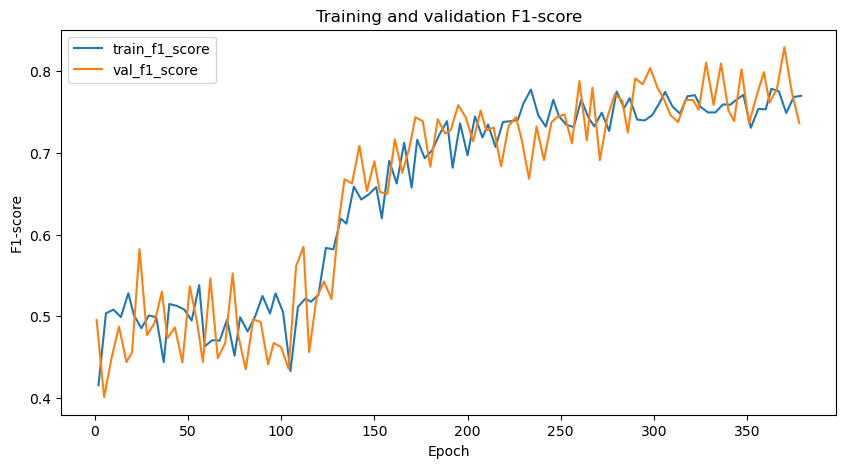

In [11]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


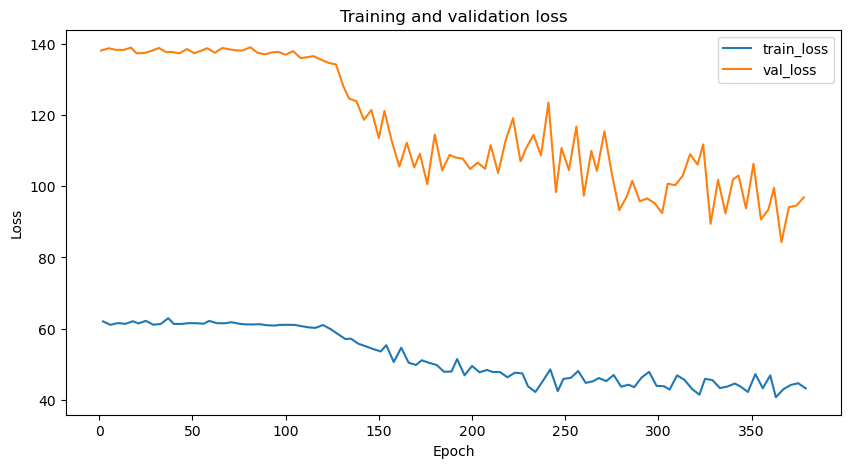

In [12]:
# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.7864735722541809     │
│         test_loss         │    113.09960174560547     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


classification report:
               precision    recall  f1-score   support

   separated       0.52      0.40      0.45       121
    adjacent       0.54      0.66      0.59       128

    accuracy                           0.53       249
   macro avg       0.53      0.53      0.52       249
weighted avg       0.53      0.53      0.52       249

F1-score:
 0.5200889547813194
Accuracy:
 0.5301204819277109


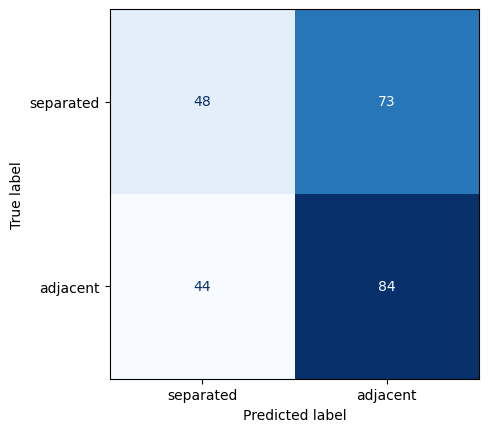

In [13]:
## TODO: FIGURE OUT WHY DIFFERENCE IN F1-SCORE BETWEEN SCIKIT-LEARN AND PYTORCH

# obtain predictions on test set and plot confusion matrix
test_loader = DataLoader(data_test, batch_size=len(data_test), shuffle=False,
                            drop_last=True)

# model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
trainer.test(model, test_loader)

# compute confusion matrix and classification report with sklearn of best model checkpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = trainer.predict(model, test_loader)
y_pred = np.concatenate(y_pred).flatten()
y_pred = np.where(y_pred == -1, 0, y_pred)
test_labels = np.where(np.array(test_labels) == -1, 0, np.array(test_labels))
y = test_labels

class_labels = ['separated', 'adjacent']
print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
print('F1-score:\n', f1_score(y, y_pred, average="macro"))
print('Accuracy:\n', (y == y_pred).sum() / len(y))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
plt.grid(False)


In [18]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'pretext_model_weights.pt')


## Extracting features